In [5]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import time
import copy
import warnings
import scipy.signal as scs
warnings.filterwarnings('ignore')
import cv2

In [54]:
## Peut être mettre de bloc là dans un fichier python à part, pour faire commes les grands ....

def visualize_block(img, block_size):

    f = 1 # facteur de recouvrement
    bs = block_size #plus court pour le code
    n,m = np.shape(img)
    fig,ax = plt.subplots(1,1,figsize=(25,15))
    ax.imshow(img)
    ncol = int(m // bs )
    to_crop_horizontal = m % bs
    nrow = int(n // bs )
    to_crop_vertical = n % bs
    nb_block = nrow * ncol      # Nombre de blocs dans l'image
    print(f"Info:\n\
    -> Shape de l'image : {n}x{m}px\n\
    -> Block size : {block_size}px\n\
    -> Nombre de blocs : {nb_block} pbs d'optim à résoudre\n\
    -> A crop horizontalement pour tomber pile : {to_crop_horizontal}px\n\
    -> A crop verticalement pour tomber pile : {to_crop_vertical}px\n")
    for i in range(nrow) :
        for j in range(ncol) :
            rect = patches.Rectangle( (j * bs, i * bs), bs, bs,linewidth=1,edgecolor='k',facecolor='none')
            ax.add_patch(rect)
    plt.show()


def calcul_deplacement(search_zone, block, bs, debug):
    n,m = np.shape(search_zone)
    x_mid = n // 2
    y_mid = m // 2
    # print(x_mid)
    x_mid_start = x_mid - (bs//4)
    y_mid_start = y_mid - (bs//4)

    s = 1 # step size
#     print(f"Nombre de positions testés méthode 2: {bs//2 - 1 **2}")
    
    f = 2*p + 1
    ncol = int(m // (bs/f) - (f - 2))
    nrow = int(n // (bs/f) - (f - 2))
    CF = np.zeros((nrow * ncol, 3))
 
    for i in range(nrow) :
        for j in range(ncol) :
            x_mid_subblock, y_mid_subblock = int((j/f) * bs + bs // 2 ) , int((i/f) * bs + bs // 2)
            left = x_mid_subblock - (bs//2)
            right = x_mid_subblock + (bs//2)
            down = y_mid_subblock - (bs//2)
            up = y_mid_subblock + (bs//2)
            
            if block.shape != (16,16) or search_zone[left:right , down:up ].shape != (16,16):
                print(block.shape)
                print(search_zone[left:right , down:up ].shape)
                print(i,j)
                print("////")

            cost = npl.norm(block - search_zone[left:right , down:up ])
            CF[i * ncol + j, 0] = y_mid_subblock - bs//2 - p # conversion milieu du bloc opti vers valeur du déplacement depuis le milieu de la zone de recherche
            CF[i * ncol + j, 1] = x_mid_subblock - bs//2 - p 
            CF[i * ncol + j, 2] = cost

    if np.max(CF[:,2]) == np.min(CF[:,2]):
        x_opti, y_opti = 0, 0
    else : 
        id_min = np.argmin(CF[:,2])
        x_opti = CF[id_min, 0]
        y_opti = CF[id_min, 1]
    
#     print(x_opti, y_opti)
    if debug == True:
        
        show_displacement(search_zone, block, CF, id_min)
        input()
    return x_opti, y_opti

def show_displacement(search_zone, block, CF, id_min):
    x_opti = CF[id_min, 0] + bs//2 + p
    y_opti = CF[id_min, 1] + bs//2 + p
    n,m = np.shape(search_zone)
    fig, ax = plt.subplots(1,2, figsize=(18,7))
    ## Search Zone
    ax[0].pcolormesh(search_zone)
    ax[0].set_title(f"Zone de recherche {search_zone.shape} | COST = {CF[id_min, 2]:.2f} | Position # {id_min}")
    ax[0].scatter(x_opti , y_opti, c= 'r')
    rect = patches.Rectangle( (x_opti - bs // 2 , y_opti - bs // 2) ,bs,bs,linewidth=1,edgecolor='k',facecolor='none')    
    horiz_bar = patches.Rectangle( (x_opti, 0), 0, n, edgecolor="r")
    vert_bar = patches.Rectangle( (0, y_opti), m, 0, edgecolor="r")
    ax[0].add_patch(horiz_bar)
    ax[0].add_patch(vert_bar)
    ax[0].add_patch(rect)
    
    ## Block
    ax[1].pcolormesh(block)
    ax[1].set_title(f"Bloc à situer | Size : {block.shape}")
    ax[1].scatter(bs//2, bs//2, c='r')
    horiz_bar = patches.Rectangle( (0, bs//2), bs, 0, edgecolor="r")
    vert_bar = patches.Rectangle( (bs//2, 0), 0, bs, edgecolor="r")
    ax[1].add_patch(horiz_bar)
    ax[1].add_patch(vert_bar)
    
    plt.suptitle(f"Déplacement : {CF[id_min, 0]}, {CF[id_min, 1]}", fontsize=12)

## Pour afficher toutes les position sur la search zone
#     rect = patches.Rectangle( (int((j/f) * bs), int((i/f) * bs)) ,bs,bs,linewidth=1,edgecolor='k',facecolor='none')
#     ax[0].scatter(int((j/f) * bs + bs // 2 ) , int((i/f) *bs + bs // 2), c= 'r')


    plt.show()

def encode_motion(iref, ipred, bs, p, debug):
    """
    Exhaustive Search sur iref avec un macrobloc issu de ipred
    """
    n, m = np.shape(ipred)[:2]
    ncol = int(m // bs)
    nrow = int(n // bs)
    u = np.zeros((nrow*ncol, 2))
    f = 2*p + 1
    print("////////////")
    print(f"{nrow * ncol} blocs | {int((bs + 2 * p) // (bs/f) - (f - 2))**2} comparaisons par bloc")
    print("////////////")
    for i in range(nrow):
        for j in range(ncol):
#     i,j = 20,20 # pour tests
            search_zone = iref[i * bs : (1 + i) * bs + 2 * p, j * bs : (1 + j) * bs + 2*p]
            block = ipred[i * bs : (1 + i) * bs, j * bs : (j + 1) * bs]
#             if block.shape != (16,16):
#                 print("€€€€")
#                 print(i,j)
#                 print(block.shape)
#                 print("€€€€")
            #             print("Shape de la zone de recherche", search_zone.shape)
            #             print("Shape du bloc", block.shape)

            u[i * ncol + j, 0], u[i * ncol + j, 1] =  calcul_deplacement(search_zone, block, bs, debug)
            if ((i * ncol + j) / (nrow * ncol) * 100 ) % 10 == 0:
                print(f'Progression : {(i * ncol + j) / (nrow * ncol) * 100 }%')
#             if (i * ncol + j) % 100 == 0:
#                 print(f'Bloc {i * ncol + j % 100} sur {nrow * ncol}')
    print("Déplacement moyen sur toute l'image :", np.mean(u[:,0]), np.mean(u[:,1]))
    return u

def decode_motion(iref, ipred, u, bs, p):
    n, m = np.shape(ipred)[:2]
    ncol = int(m // bs)
    nrow = int(n // bs)
    decoded = np.zeros(ipred.shape)
    for i in range(nrow):
        for j in range(ncol):
            ux = u[i * ncol + j, 0]
            uy = u[i * ncol + j, 1]
            iref_motioned = np.roll(np.roll(iref,-int(uy),axis=0),-int(ux),axis=1)
            decoded[i * bs :bs * (1 + i),j * bs :bs * (j + 1)] = iref_motioned[p + i * bs: p+ bs * (1 + i),p + j * bs :p + bs * (j + 1)]
    return decoded
## tester de jouer avec le padding (le tej)
    


def POC(im_t, im_tp1, bs, p, debug = False):
    n,m = np.shape(img_t)

    n_crop = n // bs  * bs
    m_crop = m // bs  * bs

    img_t_flipped_cropped = im_t[:n_crop,:m_crop]
#     img_tp1_flipped_cropped = np.flip(img_tp1[:n_crop,:m_crop, 0], axis = 0)
    img_tp1_flipped_cropped = im_tp1[:n_crop,:m_crop]

    iref = cv2.copyMakeBorder(img_t_flipped_cropped, p,p,p,p, cv2.BORDER_CONSTANT)
    n,m = np.shape(iref)
    ipred = np.copy(img_tp1_flipped_cropped)
#     iref = cv2.copyMakeBorder(img_t, p,p,p,p, cv2.BORDER_CONSTANT)
#     ipred = np.copy(img_tp1)
    print('> Encoding ...')
    u = encode_motion(iref, ipred, bs, p, debug)
    print(">>> Done")
    print('> Decoding ...')
    decoded = decode_motion(iref, ipred, u, bs, p)
    fig, ax = plt.subplots(2,1, figsize = (20,28))
    ax[0].pcolormesh(ipred-decoded).set_cmap("magma")
    ax[0].set_title('Erreur (pas absolue)')
    ax[1].pcolormesh(decoded)
    ax[1].set_title("Image prédite")
    print(">>> Norme de l'erreur", npl.norm(ipred-decoded))
    return decoded, ipred

## Avec un déplacement artificiel de 0 ----> OK

> Encoding ...


KeyboardInterrupt: 

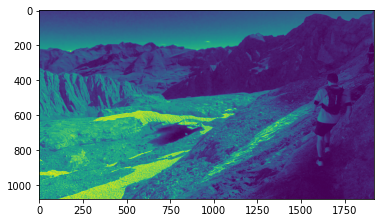

In [69]:
p = 7
bs =16
img_t = np.array(Image.open("img/1.jpg"))[:,:,0]
img_tp1 = np.copy(img_t)

plt.imshow(img_tp1)
# img_tp1 = np.array(Image.open("img/2.jpg"))
decoded, ipred = POC(img_t, img_tp1, bs, p, False)

## Avec un petit déplacement artificiel dans un seul sens (x) ----> OK

> Encoding ...


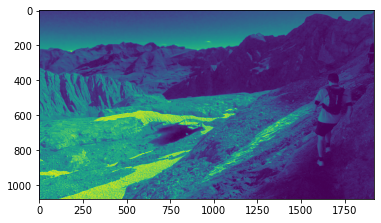

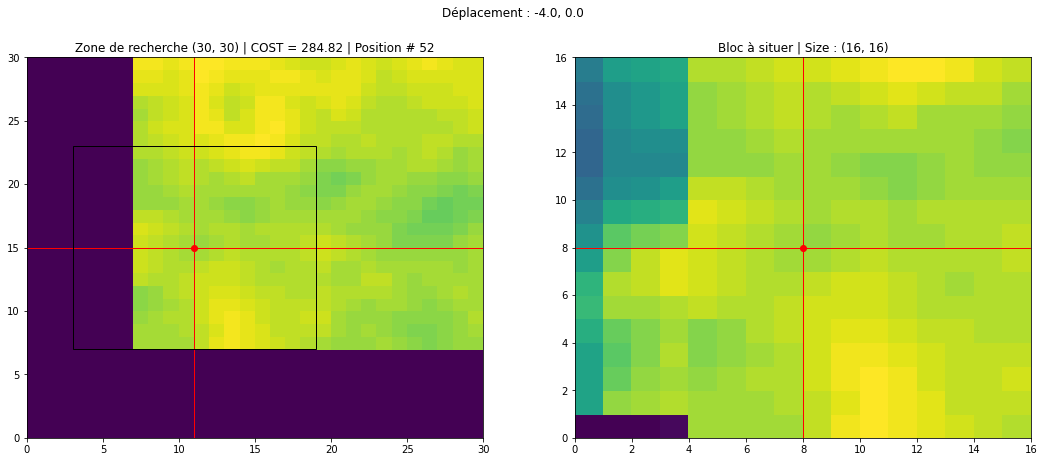

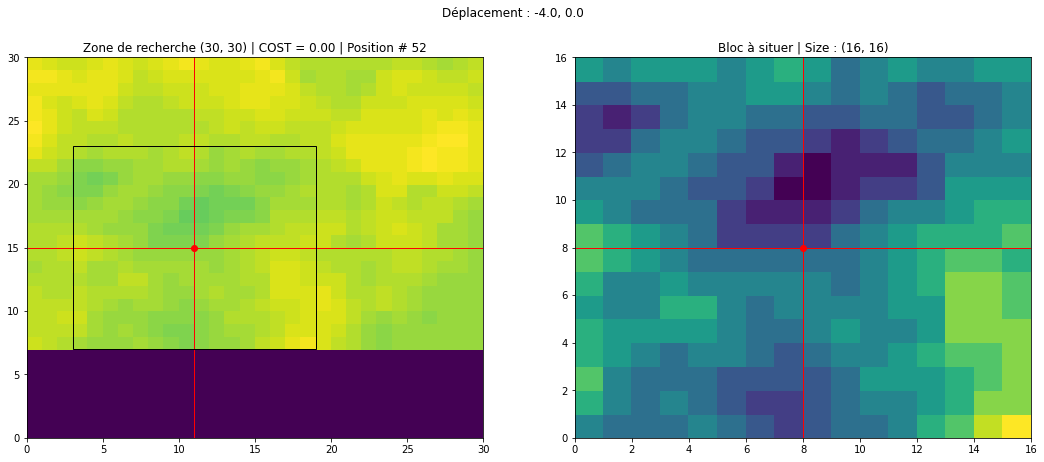

KeyboardInterrupt: Interrupted by user

In [113]:
p = 7
bs =16
img_t = np.array(Image.open("img/1.jpg"))[:,:,0]
img_tp1 = np.roll(img_t, 4)

plt.imshow(img_tp1)
# img_tp1 = np.array(Image.open("img/2.jpg"))
decoded, ipred = POC(img_t, img_tp1, bs, p, True)

## Avec un petit déplacement artificiel dans les deux sens (x,y) ----> OK

> Encoding ...
////////////
8040 blocs | 2704 comparaisons par bloc
////////////
Progression : 0.0%


KeyboardInterrupt: 

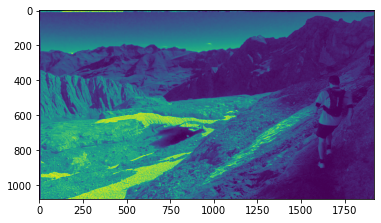

In [56]:
p = 14
bs =16
img_t = np.array(Image.open("img/1.jpg"))[:,:,0]
img_tp1 = np.roll(np.roll(img_t, 12, axis = 0), 9, axis = 1)  

plt.imshow(img_tp1)
# img_tp1 = np.array(Image.open("img/2.jpg"))
decoded, ipred = POC(img_t, img_tp1, bs, p, False)

> Encoding ...


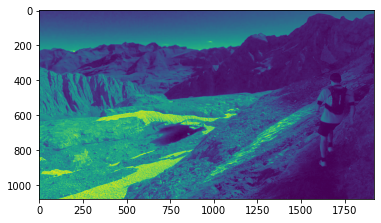

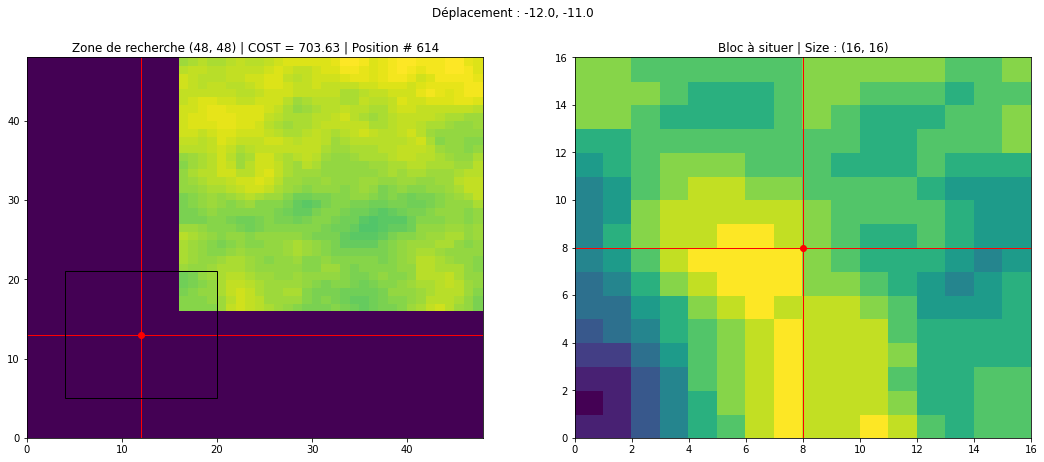

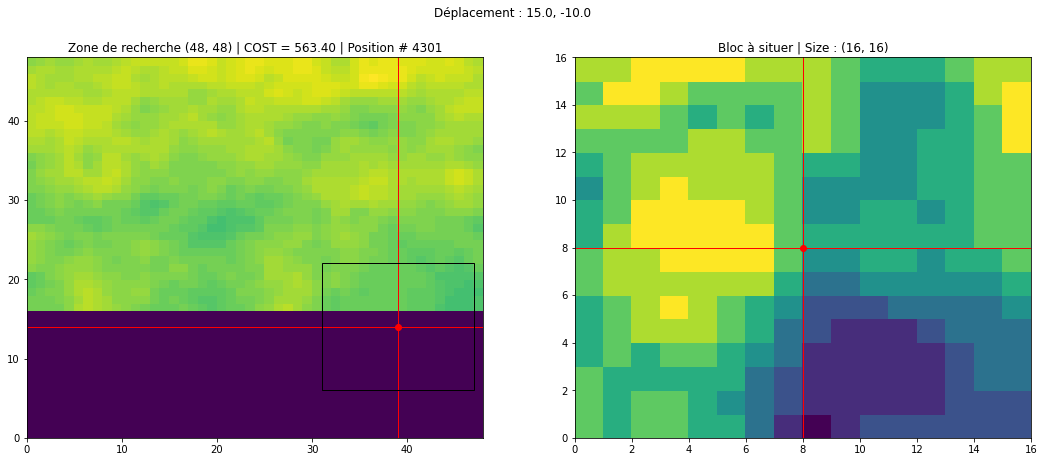

KeyboardInterrupt: Interrupted by user

In [111]:
p = 16
bs = 16
img_t = np.array(Image.open("img/1.jpg"))[:,:,0]
img_tp1 = np.array(Image.open("img/2.jpg"))[:,:,0]

plt.imshow(img_tp1)
decoded, ipred = POC(img_t, img_tp1, bs, p, True)

In [ ]:
visualize_block(img_t[:,:,0], 32)

## Test 2 : blocksize = 32, padding = 14

1056 1920
> Encoding ...
>>> Done
> Decoding ...
>>> Norme de l'erreur 52257.57863697858


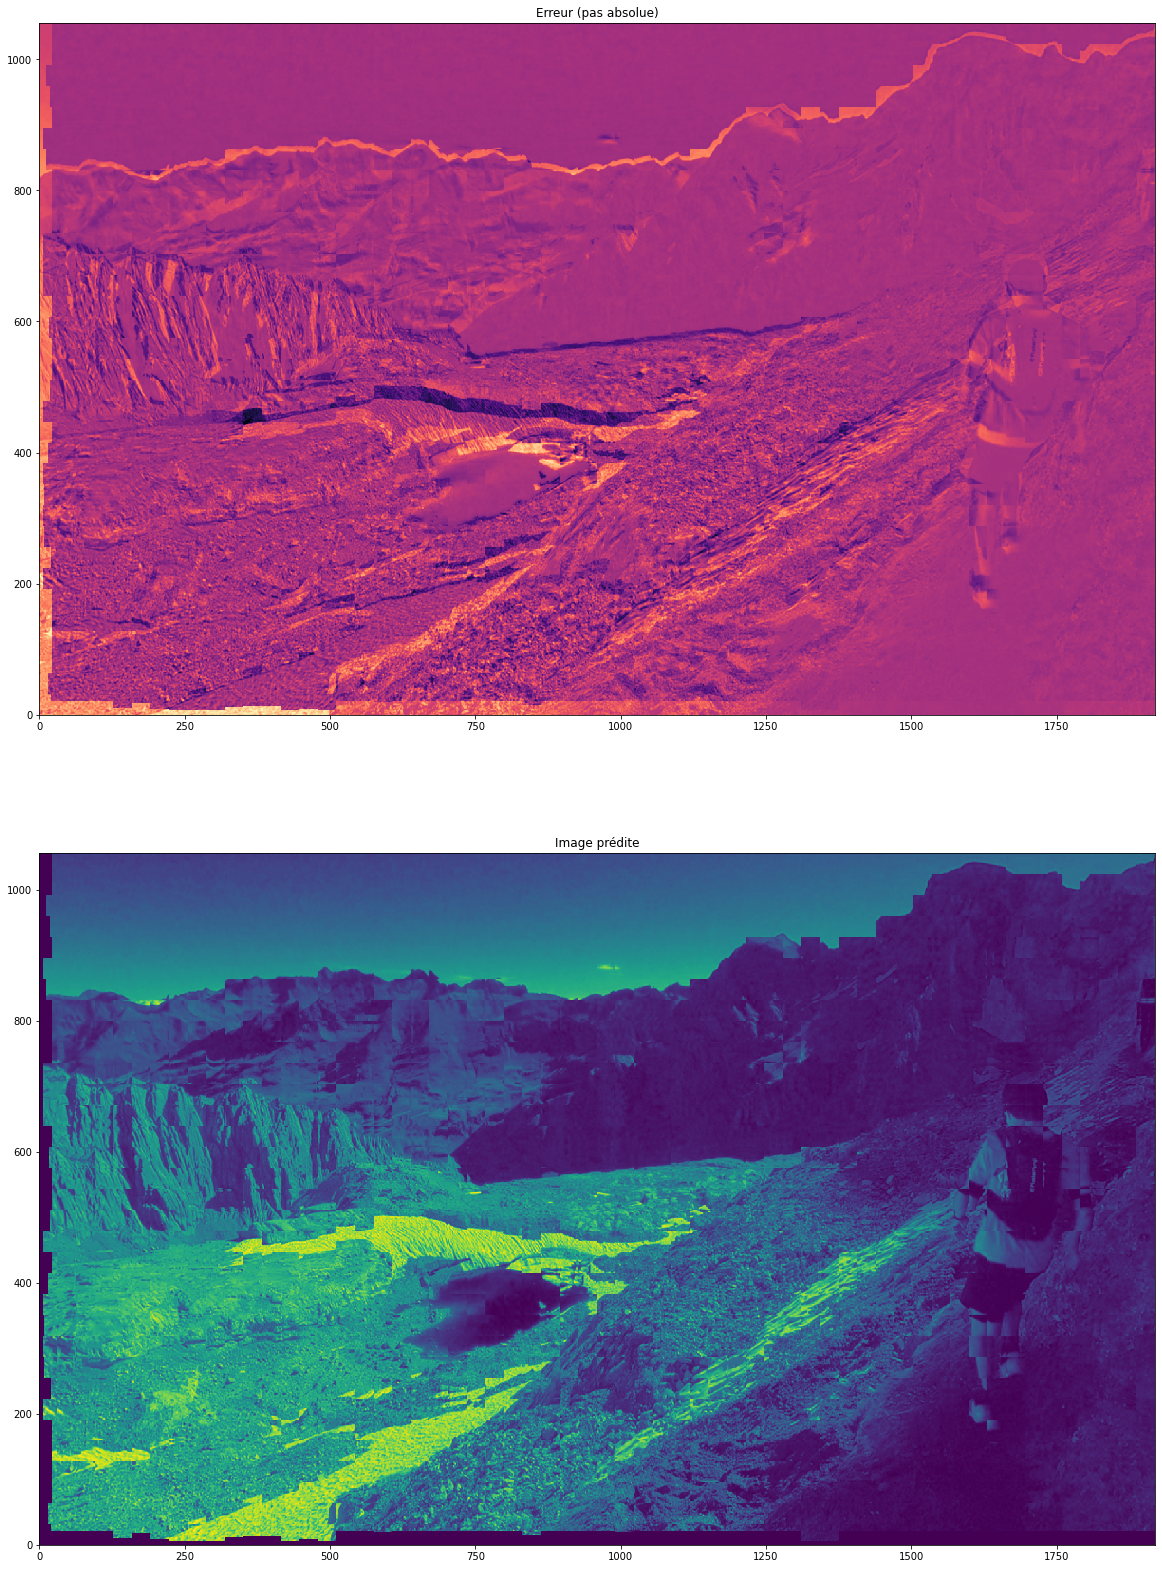

In [48]:
p = 14
bs = 32
img_t = np.array(Image.open("img/1.jpg"))
img_tp1 = np.array(Image.open("img/2.jpg"))
decoded, ipred = POC(img_t, img_tp1, bs, p)

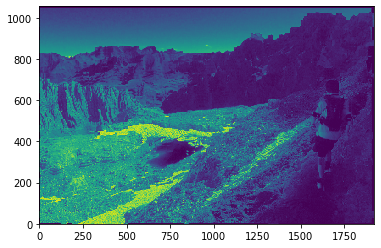

In [90]:
def get_images(n) :
    sigma=0.1
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.
              ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    g = np.roll(f, (2,1))
    return f,g


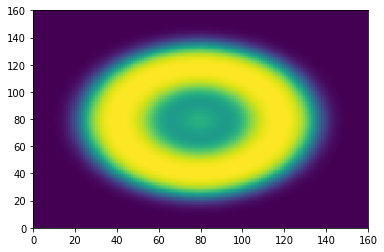

In [105]:
f,g = get_images(16*10)
plt.pcolormesh(f)

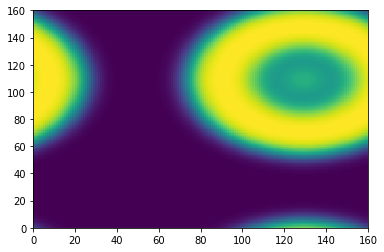

In [98]:
plt.pcolormesh(np.roll(np.roll(f, 30, axis = 0), 50, axis = 1))

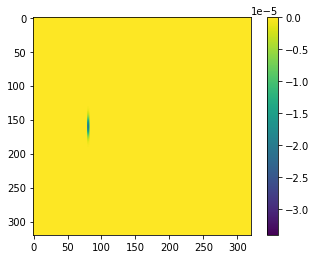

In [56]:
## POC pour notebook final sur images très simples

f,g = get_images(16*10)
pad = 16*5
p = 7
bs = 16
f = cv2.copyMakeBorder( f, pad,pad,pad,pad, cv2.BORDER_CONSTANT)
g = cv2.copyMakeBorder( g, pad,pad,pad,pad, cv2.BORDER_CONSTANT)
plt.imshow(g)
f = cv2.copyMakeBorder(f, p,p,p,p, cv2.BORDER_CONSTANT)
u = encode_motion(f, g, bs, p)
im = decode_motion(f, g, u, bs, p)
plt.imshow(im - g)
plt.colorbar()

In [3]:
### TODO
# crop l'image à un multiple de 16
# ajouter le padding de p = 7
# ajuster le parcours par bloc pour ne pas prendre en compte le padding
# boucler sur tous les blocs 16x16 de l'image
# renvoyer une matrice de vecteurs déplacement


In [4]:
## Param de test
iref = np.flip(np.array(Image.open("img/1.jpg"))[:1072,:,0], axis = 0)
axis0 = 2
axis1 = 2
ipred = np.roll(np.roll(iref,axis0,axis=0),axis1,axis=1)
p = 7
iref = cv2.copyMakeBorder( iref, p,p,p,p, cv2.BORDER_CONSTANT)